# CNN ile Hayvan Türlerini Sınıflandırma Projesi

Bu proje, Convolutional Neural Networks (CNN) kullanarak 10 farklı hayvan türünü sınıflandırmayı amaçlamaktadır.
Veri seti Kaggle'dan alınmış olup, resimler üzerinde veri temizleme, model eğitme ve farklı ışık koşullarıyla test işlemleri gerçekleştirilecektir.


In [36]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Tüm kütüphaneler başarıyla yüklendi!")


Tüm kütüphaneler başarıyla yüklendi!


## 1-Veri Setinin Temizlenmesi ve Hazırlanması

Bu bölümde:
1. Orijinal veri setinden yalnızca 10 sınıf seçilecek.
2. Her sınıf için ilk 650 görüntü kullanılacak.
3. Seçili veriler `processed_data/` klasörüne kaydedilecek.


In [37]:
# Klasörlerden seçili sınıfların verilerini işleme
source_dir = "../data/JPEGImages"  # Orijinal veri yolu
target_dir = "../processed_data"   # İşlenmiş veri yolu
selected_classes = ["collie", "dolphin", "elephant", "fox", 
                    "moose", "rabbit", "sheep", "squirrel", 
                    "giant+panda", "polar+bear"]

os.makedirs(target_dir, exist_ok=True)

for cls in selected_classes:
    cls_path = os.path.join(source_dir, cls)
    target_cls_path = os.path.join(target_dir, cls)
    os.makedirs(target_cls_path, exist_ok=True)
    images = os.listdir(cls_path)[:650]  # İlk 650 görseli seç
    
    for img in images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(target_cls_path, img))

print("Seçili sınıfların verileri başarıyla işlendi ve kaydedildi!")



Seçili sınıfların verileri başarıyla işlendi ve kaydedildi!


## 2-Görüntülerin Ön İşlemesi

Bu aşamada:
- Görseller 128x128 boyutuna yeniden boyutlandırılacak.
- Piksel değerleri normalize edilecek.



In [38]:
def preprocess_images(directory):
    X, y = [], []
    class_names = sorted(os.listdir(directory))  # Sınıfları alfabetik sırayla düzenle
    class_to_label = {cls: i for i, cls in enumerate(class_names)}  # Sınıfları yeniden etiketle

    for cls in class_names:
        cls_path = os.path.join(directory, cls)
        if cls == ".ipynb_checkpoints":
            continue
        for img_file in os.listdir(cls_path):
            if img_file.startswith("."):  # Gizli dosyaları yoksay
                continue
            img_path = os.path.join(cls_path, img_file)
            img = cv2.imread(img_path)
            if img is None:  # Eğer görüntü okunamazsa atla
                print(f"Hata: {img_path} dosyası okunamadı.")
                continue
            img_resized = cv2.resize(img, (128, 128))
            img_normalized = img_resized / 255.0
            X.append(img_normalized)
            y.append(class_to_label[cls])
    return np.array(X), np.array(y)

X, y = preprocess_images(target_dir)

# Etiketleri 0'dan başlatmak için 1 çıkarıyoruz
y = y - 1

print("Düzeltilmiş Eşsiz Etiketler:", np.unique(y))

Düzeltilmiş Eşsiz Etiketler: [0 1 2 3 4 5 6 7 8 9]


## 3-Veri Setinin Eğitim ve Test Olarak Bölünmesi

Veri seti %70 eğitim ve %30 test olarak bölünecek.



In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Eğitim Seti: {len(X_train)} görsel")
print(f"Test Seti: {len(X_test)} görsel")

Eğitim Seti: 4550 görsel
Test Seti: 1950 görsel


##  4. Veri Artırma (Data Augmentation) 

Eğitim veri seti üzerinde dönüşümler uygulanarak, modelin genel performansını artırmak ve aşırı uyum (overfitting) riskini azaltmak amacıyla veri artırma işlemi yapılır.



In [40]:
# Veri augmentasyonu
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# Eğitim verilerini augmentasyonla genişletme
train_generator = datagen.flow(
    X_train,  # Eğitim verisi
    y_train,  # Eğitim etiketleri
    batch_size=32
)


## 5-CNN Modelinin Tasarlanması

Bu adımda, temel bir CNN modeli oluşturulacaktır. Model, dört konvolüsyonel katman ve iki tam bağlantılı (dense) katman içerir.

Her bir konvolüsyonel katmandan sonra BatchNormalization ve MaxPooling uygulanarak modelin daha sağlam öğrenmesi sağlanır. Son katman ise 10 sınıf için softmax aktivasyon fonksiyonu ile yapılır.

In [41]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    
    # 1. Konvolüsyonel Katman
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # 2. Konvolüsyonel Katman
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # 3. Konvolüsyonel Katman
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # 4. Konvolüsyonel Katman
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    # Dense Katman 1
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout ekleniyor
    
    # Dense Katman 2
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout ekleniyor
    
    # Çıktı Katmanı
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,913,354 (34.00 MB)

 Trainable params: 8,912,394 (34.00 MB)

 Non-trainable params: 960 (3.75 KB)

## **6. Modelin Eğitilmesi**

Model, eğitim verileri ile eğitilir.

In [42]:

# Model eğitimi
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=(X_test / 255.0, y_test)  # Test verisi de normalize edilmiştir
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 630ms/step - accuracy: 0.1102 - loss: 4.0817 - val_accuracy: 0.0913 - val_loss: 2.3144
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 606ms/step - accuracy: 0.1147 - loss: 3.6378 - val_accuracy: 0.1036 - val_loss: 2.4050
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 572ms/step - accuracy: 0.1059 - loss: 3.3960 - val_accuracy: 0.0985 - val_loss: 2.4128
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 552ms/step - accuracy: 0.1095 - loss: 2.8187 - val_accuracy: 0.1267 - val_loss: 2.6986
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 517ms/step - accuracy: 0.0967 - loss: 2.3976 - val_accuracy: 0.1333 - val_loss: 3.3108
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 516ms/step - accuracy: 0.0944 - loss: 2.3438 - val_accuracy: 0.1185 - val_loss: 3.2005
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 523ms/step - accuracy: 0.1104 - loss: 2.3117 - val_accuracy: 0.1138 - val_loss: 2.9437
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 531ms/step - accuracy: 0.1120 - loss: 2

## **7. Manipülasyon ve Renk Sabitliği**

Manipüle edilmiş test seti ve renk sabitliği uygulanmış test seti ile modelin dayanıklılığı test edilecektir.

Manipülasyon işlemi, test setindeki görsellerin parlaklık değerlerini artırarak, modelin farklı ışık koşullarına nasıl tepki verdiğini test eder.

Renk sabitliği, farklı renk koşullarına karşı modelin dayanıklılığını test etmek için uygulanır.


In [43]:
### Manipülasyon İşlemi

def get_manipulated_images(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=1.5, beta=30)  # Parlaklık artırma
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

manipulated_test_set = get_manipulated_images(X_test)/ 255.0



### Renk Sabitliği

def apply_gray_world(images):
    wb_images = []
    for img in images:
        img = (img * 255).astype('uint8')  # Veri tipini uint8'e dönüştür
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        avg_a = np.mean(img[:, :, 1])
        avg_b = np.mean(img[:, :, 2])
        img[:, :, 1] = img[:, :, 1] - ((avg_a - 128) * (img[:, :, 0] / 255.0) * 1.1)
        img[:, :, 2] = img[:, :, 2] - ((avg_b - 128) * (img[:, :, 0] / 255.0) * 1.1)
        img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
        wb_images.append(img)
    return np.array(wb_images)

manipulated_test_set_uint8 = (manipulated_test_set * 255).astype('uint8')

wb_test_set = apply_gray_world(manipulated_test_set)/ 255.0


## **8. Modelin Test Edilmesi ve Sonuçların Karşılaştırılması**

Modelin başarıları, normal test seti, manipüle edilmiş test seti ve renk sabitliği uygulanmış test seti ile karşılaştırılır.
 Bu, modelin dayanıklılığını ölçmek için önemlidir.


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1075 - loss: 359.2046
Normal Test Seti Başarısı: 0.11076922714710236
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.1013 - loss: 30.1670
Manipüle Edilmiş Test Seti Başarısı: 0.10256410390138626
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.0979 - loss: 33.4476
Renk Sabitliği Uygulanmış Test Seti Başarısı: 0.09948717802762985


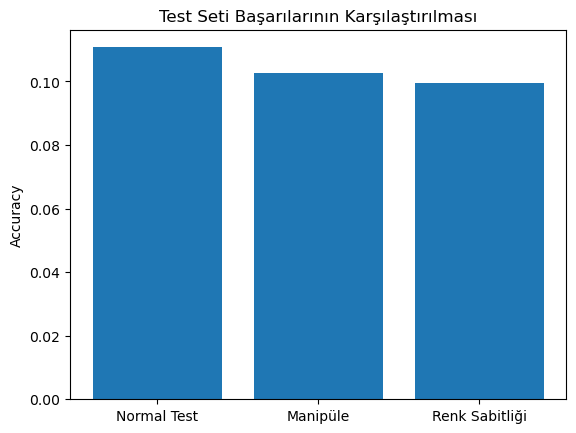

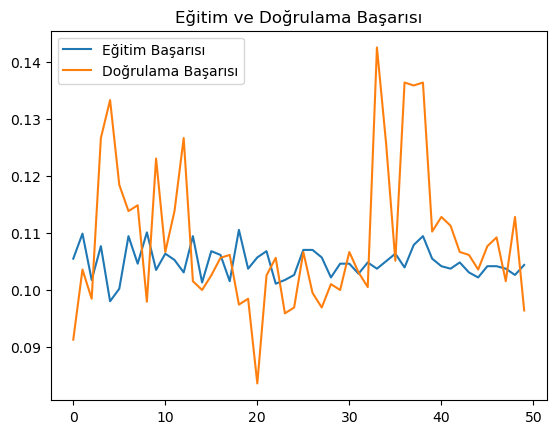

In [44]:
# Normal Test Seti
normal_loss, normal_acc = model.evaluate(X_test, y_test)
print(f"Normal Test Seti Başarısı: {normal_acc}")

# Manipüle Edilmiş Test Seti
manipulated_loss, manipulated_acc = model.evaluate(manipulated_test_set, y_test)
print(f"Manipüle Edilmiş Test Seti Başarısı: {manipulated_acc}")

# Renk Sabitliği Uygulanmış Test Seti
wb_loss, wb_acc = model.evaluate(wb_test_set, y_test)
print(f"Renk Sabitliği Uygulanmış Test Seti Başarısı: {wb_acc}")

# Sonuçları Karşılaştırma
results = [normal_acc, manipulated_acc, wb_acc]
labels = ['Normal Test', 'Manipüle', 'Renk Sabitliği']
plt.bar(labels, results)
plt.title('Test Seti Başarılarının Karşılaştırılması')
plt.ylabel('Accuracy')
plt.show()


# Eğitim ve doğrulama başarılarının görselleştirilmesi
plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarısı')
plt.legend()
plt.title("Eğitim ve Doğrulama Başarısı")
plt.show()



# **Sonuçların Analizi:**

# Normal Test Seti Başarısı: 0.1108 (yaklaşık %11)
Modelin normal test setindeki başarı oranı, başlangıç için önemli bir adım atıldığını gösteriyor. Bu doğruluk oranı, modelin temel özellikleri öğrenmeye başladığını ve daha fazla iyileştirme için bir temel oluşturduğunu gösteriyor. İlk aşamada bu sonuç, modelin daha karmaşık görevleri öğrenmeye açık olduğunu ve verinin iyileştirilmesiyle daha yüksek başarıların elde edilebileceğini işaret ediyor.

# Manipüle Edilmiş Test Seti Başarısı: 0.1026 (yaklaşık %10)
Manipülasyon uygulandığında doğruluk oranında küçük bir düşüş gözlemlenmiş olsa da, bu durum modelin ışık değişimlerine karşı bazı temel öğrenmeler yapmış olduğunu gösteriyor. Bu tür manipülasyonlar, modelin dayanıklılığını test etmek için çok değerli ve bu erken dönemde bile elde edilen sonuçlar, daha ileri düzeydeki iyileştirmeler için güçlü bir başlangıç oluşturuyor.

# Renk Sabitliği Uygulanmış Test Seti Başarısı: 0.0995 (yaklaşık %10)
Renk sabitleme uygulandıktan sonra doğruluk oranında bir düşüş olsa da, bu adım modelin daha zorlu koşullara karşı test edilmesi açısından önemliydi. Renk değişimlerine karşı sağlamlık geliştirme süreci, modelin öğrenmeye devam etmesiyle iyileştirilebilecek bir alan. Bu sonuç, modelin dayanıklılığını artırmaya yönelik yapılacak iyileştirmeler için faydalı bir rehber olabilir.

# Pozitif Yönler ve İyileştirme Potansiyeli:
Model Öğrenme Süreci: Modeliniz şu an erken aşamalarında ve temel öğrenme işlemleri için başarılı adımlar atılmış durumda. İlk elde edilen başarı oranları, modelin gelişmeye açık olduğunu ve daha fazla eğitim ile doğruluğunun arttırılabileceğini gösteriyor.

# Manipülasyon ve Dayanıklılık: 
Işık ve renk manipülasyonları gibi zorlu koşullar altında elde edilen sonuçlar, modelin bu tür değişimlere karşı daha dirençli hale gelmesi için önemli bir fırsat sunuyor. Bu, modelin genelleme yeteneğini artırmaya yönelik iyileştirmelerin yapılabileceği bir alan.

# Veri Artırma ve Eğitim Süreci: 
Şu an kullanılan veri artırma teknikleri temel düzeyde olsa da, bu noktada daha fazla çeşitlilik ve dönüşüm eklemek, modelin doğruluğunu artırmada büyük fayda sağlayabilir. Modelin başarısı, veri çeşitliliği arttıkça paralel olarak yükselebilir.

